In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
# ------------------ shared: lexicon labeling ------------------
import re
import pandas as pd
import numpy as np

# Expanded lexicons (you can further expand)
positive_words = [
    "gain","gains","gained","rally","rallies","rallied","growth","growing","rise","rises","rising",
    "soar","soars","soared","surge","surges","surged","jump","jumps","jumped","spike","spikes","spiked",
    "increase","increases","increased","higher","strength","strengthen","strengthened",
    "record","record-high","record breaking","all time high","beat","beats","beating","topped","tops",
    "exceed","exceeds","exceeded","outperform","outperforms","outperformed","above expectations",
    "profit","profits","profitable","margin expansion","raised forecast","upgrade","upgraded","improved",
    "recovery","rebound","bounce back","bullish","optimistic","resilient","solid","robust","momentum",
    "expands","expanding","expansion","success","secured","partnership","acquires","launch","launched",
    "innovation","breakthrough","best","better","stronger","positive","boost","boosted","skyrocket"
]

negative_words = [
    "loss","losses","losing","drop","drops","dropped","decline","declines","declined",
    "fall","falls","fell","selloff","sell-off","plunge","plunges","plunged","tumble","tumbles","tumbled",
    "slump","slumps","slumped","weak","weaker","weakness","downturn","slowdown","cooling demand",
    "missed expectations","miss","misses","missed","earnings miss","cuts forecast","cut forecast",
    "lower guidance","warn","warns","warning","profit slump","loss widening","margin compression",
    "downgrade","downgrades","downgraded","layoff","layoffs","job cuts","fired","recall","recalled",
    "bankrupt","bankruptcy","collapse","collapsed","probe","investigation","lawsuit","sued","sue","sues",
    "fraud","fraudulent","data breach","breach","fine","fined","penalty","risk","risks","uncertainty",
    "volatility","sell pressure","pullback","shortage","shortfall","delays","disruption","spooked"
]

neutral_words = [
    "news","update","report","reports","statement","statements","announces","announce","announcement",
    "says","said","according","reveals","revealed","shows","show","coverage","story","details","highlights",
    "press release","media","article","interview","note","notes","expected","scheduled","meeting","conference"
]

_url_pat = re.compile(r"http\S+|www\.\S+")
_nonalpha_pat = re.compile(r"[^a-z\s]")
_multispace_pat = re.compile(r"\s+")

def clean_text_basic(s: str) -> str:
    s = str(s).lower()
    s = _url_pat.sub(" ", s)
    s = _nonalpha_pat.sub(" ", s)
    s = _multispace_pat.sub(" ", s).strip()
    return s

def create_label(text: str) -> int:
    t = str(text).lower()
    # positive first
    for w in positive_words:
        if w in t:
            return 2
    for w in negative_words:
        if w in t:
            return 0
    for w in neutral_words:
        if w in t:
            return 1
    return 1


In [12]:
# 2. LOAD TRAINING CSV (IGNORE LABEL COLUMN)
df = pd.read_csv("synthetic_10000_news_shuffled.csv")   # path to your data
df = df[["headline"]]

In [13]:
# 2. Split BEFORE preprocessing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [14]:
# 3. Preprocess
train_df["clean"] = train_df["headline"].apply(clean_text_basic)
test_df["clean"]  = test_df["headline"].apply(clean_text_basic)

In [15]:
# 4. Label via lexicon (weak supervision)
train_df["label"] = train_df["clean"].apply(create_label).astype(int)
test_df["label"]  = test_df["clean"].apply(create_label).astype(int)

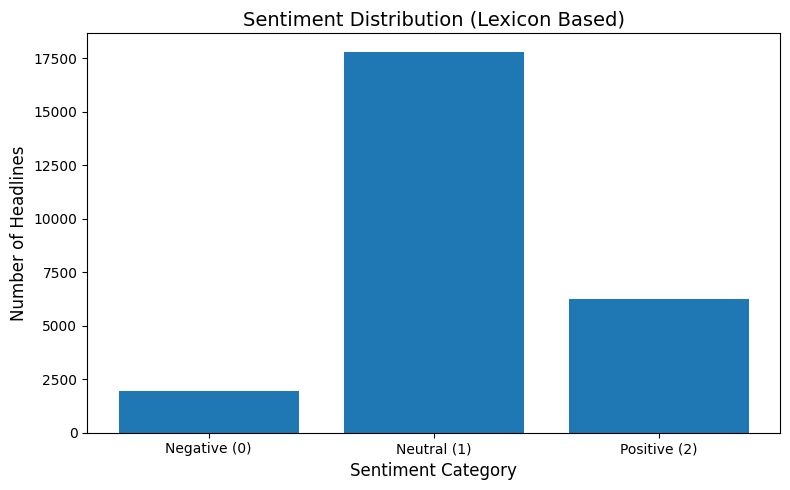

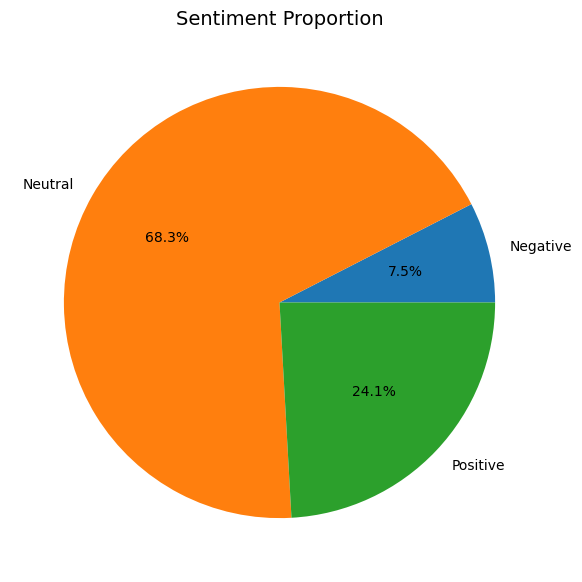

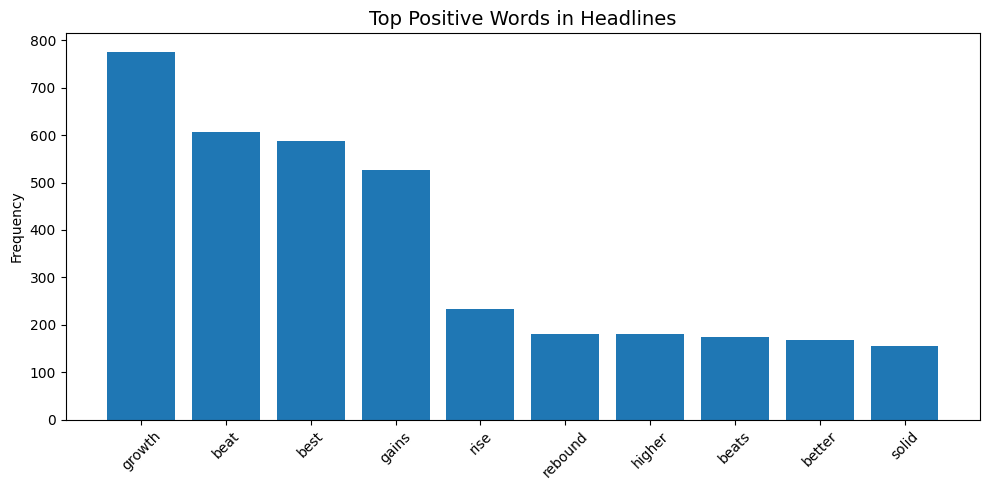

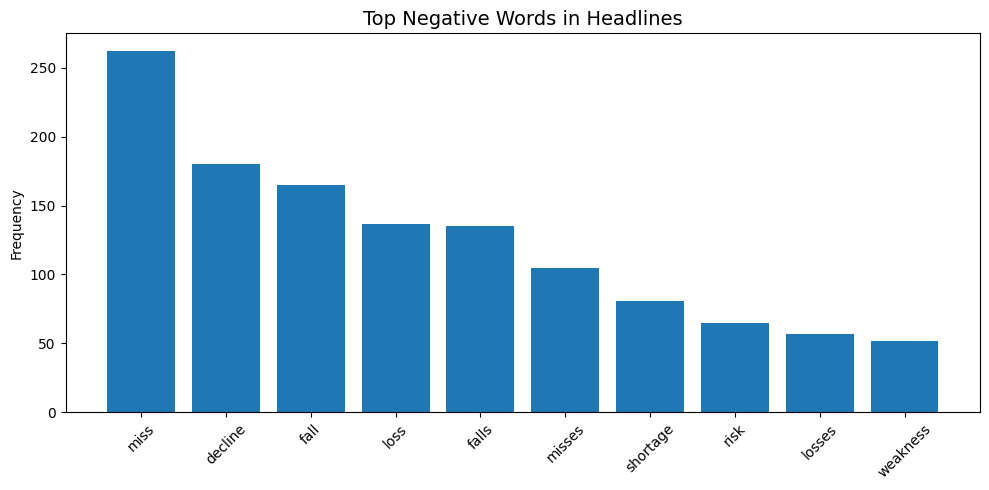

In [25]:
# ---------------- VISUALIZATION OF LEXICON-LABELED NEWS ------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

# ----------------- (USE YOUR EXISTING FUNCTIONS) -------------------------
# clean_text_basic(), create_label(), positive_words, negative_words, neutral_words

df = pd.read_csv("stock_news.csv")   # your dataset
df = df[["headline"]]

# Add sentiment labels
df["cleaned"] = df["headline"].apply(clean_text_basic)
df["sentiment"] = df["headline"].apply(create_label)   # 0=neg,1=neutral,2=positive

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# ---------------------- VISUALIZATION 1: BAR CHART -----------------------
plt.figure(figsize=(8,5))
counts = df["sentiment"].value_counts().sort_index()

plt.bar(["Negative (0)", "Neutral (1)", "Positive (2)"], counts)
plt.title("Sentiment Distribution (Lexicon Based)", fontsize=14)
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Number of Headlines", fontsize=12)
plt.tight_layout()
plt.show()

# ---------------------- VISUALIZATION 2: PIE CHART -----------------------
plt.figure(figsize=(7,7))
plt.pie(counts, labels=["Negative","Neutral","Positive"], autopct="%1.1f%%")
plt.title("Sentiment Proportion", fontsize=14)
plt.show()

# -------------- VISUALIZATION 3: WORD FREQUENCY (OPTIONAL) --------------
all_text = " ".join(df["cleaned"].tolist()).split()

# Count only positive and negative word occurrences
positive_counts = Counter([w for w in all_text if w in positive_words])
negative_counts = Counter([w for w in all_text if w in negative_words])

top_pos = positive_counts.most_common(10)
top_neg = negative_counts.most_common(10)

# Plot top positive words
plt.figure(figsize=(10,5))
plt.bar([w for w, c in top_pos], [c for w, c in top_pos])
plt.title("Top Positive Words in Headlines", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot top negative words
plt.figure(figsize=(10,5))
plt.bar([w for w, c in top_neg], [c for w, c in top_neg])
plt.title("Top Negative Words in Headlines", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# If earlier you did: df["cleaned"] = df["headline"].apply(clean_text_basic)
# and then train_df, test_df = train_test_split(df, ...)

vectorizer = TfidfVectorizer(max_features=80000, ngram_range=(1,2), min_df=2)
X_train = vectorizer.fit_transform(train_df["cleaned"])
X_test  = vectorizer.transform(test_df["cleaned"])

In [29]:
# 1. Make sure sentiment labels exist before splitting
df["sentiment"] = df["headline"].apply(create_label)   # 0=neg, 1=neutral, 2=positive

# 2. Clean text
df["cleaned"] = df["headline"].apply(clean_text_basic)

# 3. Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# 4. Vectorize using the correct column name
vectorizer = TfidfVectorizer(max_features=80000, ngram_range=(1,2), min_df=2)
X_train = vectorizer.fit_transform(train_df["cleaned"])
X_test  = vectorizer.transform(test_df["cleaned"])

# 5. Extract correct y labels
y_train = train_df["sentiment"]
y_test  = test_df["sentiment"]

# 6. Train Logistic Regression
model = LogisticRegression(
    C=1.0,
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


In [30]:
# 7. Eval
preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.9553846153846154
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       397
           1       0.97      0.98      0.97      3532
           2       0.98      0.92      0.95      1271

    accuracy                           0.96      5200
   macro avg       0.91      0.92      0.92      5200
weighted avg       0.96      0.96      0.96      5200



In [31]:
out = test_df.copy()
out["pred"] = preds
out["pred_proba"] = list(model.predict_proba(X_test)) if hasattr(model, "predict_proba") else None
display(out.head(20))

,headline,cleaned,sentiment,pred,pred_proba
4148,Applied Materials Gives Weak Forecast as Short...,applied materials gives weak forecast as short...,0,0,"[0.8410610300724687, 0.05884027609031804, 0.10..."
7841,Rockwell Automation (ROK) Q2 Earnings & Sales ...,rockwell automation rok q earnings sales miss ...,0,0,"[0.917762582234107, 0.027734977867468365, 0.05..."
18898,CSX (CSX) Stock Sinks As Market Gains: What Yo...,csx csx stock sinks as market gains what you s...,2,2,"[0.005539879635412005, 0.025470390947120322, 0..."
4194,5 Things About Take Two Interactive Smart Inve...,things about take two interactive smart invest...,1,1,"[0.04604746701863762, 0.8442243338350318, 0.10..."
8409,Pacific Coast Building Products buys $13 milli...,pacific coast building products buys million r...,1,1,"[0.09941864322978151, 0.7914833433926322, 0.10..."
24725,2 Reasons XPEL Could Excel,reasons xpel could excel,1,1,"[0.1754030201431971, 0.6179028831171585, 0.206..."
2508,Semiconductor Sales Hit All-Time High: 4 Solid...,semiconductor sales hit all time high solid st...,2,2,"[0.048237612333350555, 0.12342731417743939, 0...."
20879,Investors in PACCAR (NASDAQ:PCAR) have made a ...,investors in paccar nasdaq pcar have made a re...,1,1,"[0.07709261391830535, 0.7050674160948234, 0.21..."
17758,Wellmark® Selects Principal® as Workplace Reti...,wellmark selects principal as workplace retire...,1,1,"[0.10307667314171452, 0.6353605984697162, 0.26..."
2905,"Omnicom (OMC) Q1 Earnings Surpass Estimates, I...",omnicom omc q earnings surpass estimates incre...,2,2,"[0.03590955133137213, 0.24812220481700653, 0.7..."
